# Audio Classification

## Preprocessing

* All input audio files are processed to equal lengths using zero padding or cutting
* Audio downsampled to 22050 from 41000 to reduce complexity
* Mel Frequency Cepstral Coefficients (MFCC) used for collecting features
* MFCC converted the audio classification task to an image classification task

## Training procedure

* Transfer learning using pretrained DenseNet for classifying the data. Resnet18, various CNN and RNN models were also tried out, but the results were unsatisfactory.
* Optimizer used is Adam with learning rate = 1e-3.
* Criterion used is Cross Entropy Loss
* Scheduler used StepLR whose parameters are from the PyTorch docs
* Training epochs: 20

## Final results

* Training & validation accuracy: 98% (similar due to small train test split)
* Plots have been made towards the end of the report


## Train

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder

from models.densenet import DenseNet
from utils import audio_loader, train, valid, predict


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Version:", torch.__version__)
print("Device:", device)


Version: 1.9.0+cu111
Device: cuda:0


In [3]:
RESULT_DIR = Path('./results')
CHECKPOINT_DIR = Path('./checkpoints')
RESULT_DIR.mkdir(exist_ok=True)
CHECKPOINT_DIR.mkdir(exist_ok=True)

# ? hyperparams
BATCH_SIZE = 2
TRAIN_TEST_SPLIT = 0.8
EPOCHS = 20


### Load dataset

In [4]:
dataset = DatasetFolder(root='./dataset', loader=audio_loader, extensions='wav')
print(f"Input shape: {tuple(dataset[0][0].shape)}")

classes = dataset.classes
print("Classes:", classes)

train_size = int(TRAIN_TEST_SPLIT * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# ? dataloader
train_loader = DataLoader(train_dataset.dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset.dataset, batch_size=BATCH_SIZE, shuffle=True)


Input shape: (1, 64, 442)
Classes: ['1', '2', '3', '4', '5', '6', '7']


C:\Python39\lib\site-packages\torchaudio\functional\functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### Model, optimizers and criterion

In [5]:
model = DenseNet(len(classes))
model.to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS//3, gamma=0.1)


DenseNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True

### Training and validation

In [6]:
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

writer = SummaryWriter(comment="audio_classification_densenet")

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(
        model, train_loader, criterion=criterion, optimizer=optimizer, device=device
    )
    valid_loss, valid_accuracy = valid(
        model, valid_loader, criterion=criterion, device=device
    )

    scheduler.step()

    writer.add_scalar('training loss/train_loss', train_loss, epoch)
    writer.add_scalar('validation loss/valid_loss', valid_loss, epoch)

    writer.add_scalar('training accuracy/train_acc', train_accuracy, epoch)
    writer.add_scalar('validation accuracy/valid_acc', valid_accuracy, epoch)

    writer.add_scalar('learning rate/lr', optimizer.param_groups[0]['lr'], epoch)

    train_losses.append(train_loss), train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss), valid_accuracies.append(valid_accuracy)

    print(
        f'[Epoch: {epoch}/{EPOCHS}]\t'
        f'Training (Loss, Accuracy): ({train_loss:.6f}, {train_accuracy:.2f}%)\t'
        f'Validation (Loss, Accuracy): ({valid_loss:.6f}, {valid_accuracy:.2f}%)\t'
    )

    if epoch % 5 == 0:
        torch.save(model.state_dict(), CHECKPOINT_DIR / f'densenet_epoch_{epoch}.pth')

writer.close()


C:\Python39\lib\site-packages\torchaudio\functional\functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
C:\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch: 1/20]	Training (Loss, Accuracy): (0.993889, 12.61%)	Validation (Loss, Accuracy): (1.501447, 45.38%)	
[Epoch: 2/20]	Training (Loss, Accuracy): (0.859027, 34.45%)	Validation (Loss, Accuracy): (1.183174, 66.39%)	
[Epoch: 3/20]	Training (Loss, Accuracy): (0.788107, 40.34%)	Validation (Loss, Accuracy): (0.792361, 80.67%)	
[Epoch: 4/20]	Training (Loss, Accuracy): (0.656254, 57.98%)	Validation (Loss, Accuracy): (0.624768, 84.87%)	
[Epoch: 5/20]	Training (Loss, Accuracy): (0.614129, 63.03%)	Validation (Loss, Accuracy): (0.522614, 83.19%)	
[Epoch: 6/20]	Training (Loss, Accuracy): (0.505348, 74.79%)	Validation (Loss, Accuracy): (0.255128, 96.64%)	
[Epoch: 7/20]	Training (Loss, Accuracy): (0.396607, 86.55%)	Validation (Loss, Accuracy): (0.264759, 94.96%)	
[Epoch: 8/20]	Training (Loss, Accuracy): (0.363856, 90.76%)	Validation (Loss, Accuracy): (0.231102, 94.96%)	
[Epoch: 9/20]	Training (Loss, Accuracy): (0.408310, 88.24%)	Validation (Loss, Accuracy): (0.211544, 97.48%)	
[Epoch: 10/20]	Trai

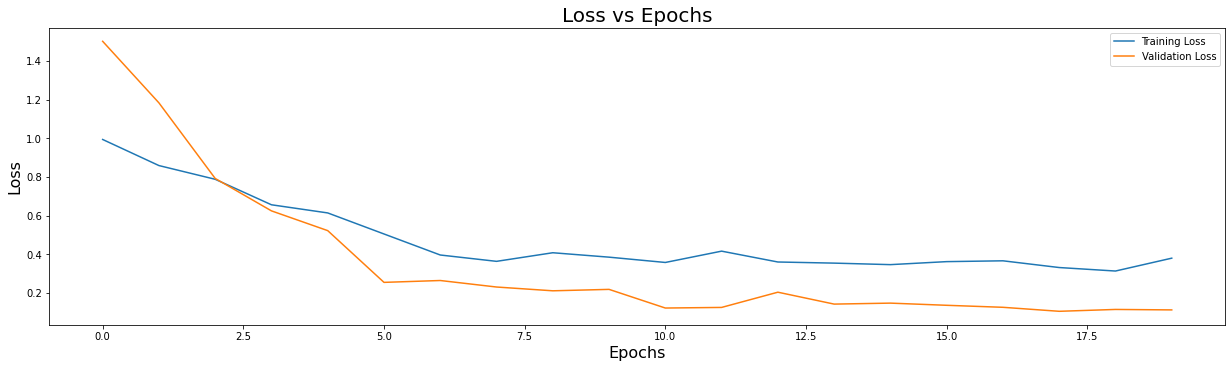

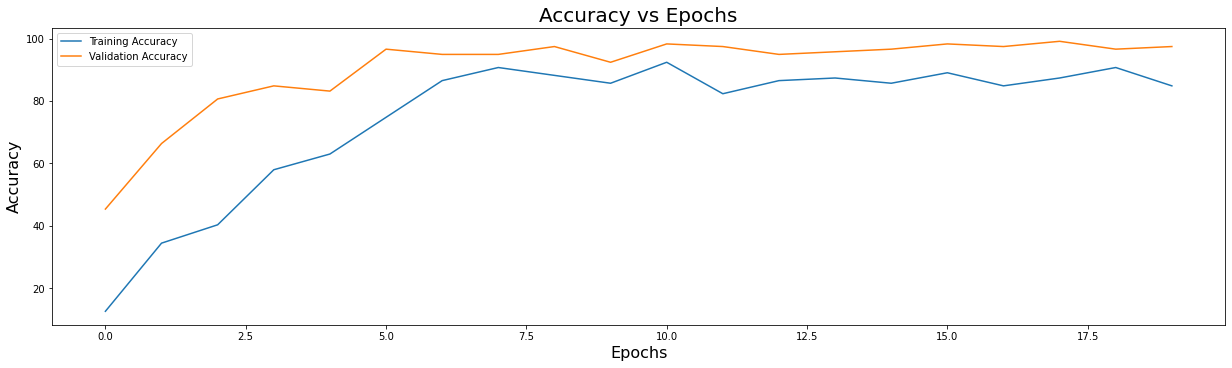

In [7]:
plt.figure(figsize=(17, 5), constrained_layout=True)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss vs Epochs', fontsize=20)
plt.savefig(RESULT_DIR / 'train_loss_vs_epochs.png', facecolor="w", transparent=False)
plt.show()

plt.figure(figsize=(17, 5), constrained_layout=True)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs Epochs', fontsize=20)
plt.savefig(RESULT_DIR / 'train_accuracy_vs_epochs.png', facecolor="w", transparent=False)
plt.show()


## Test Dataset

* Load model
* Classify test data


In [10]:
classes = ['1', '2', '3', '4', '5', '6', '7']
MODEL_PATH = CHECKPOINT_DIR / 'densenet_epoch_20.pth'

def make_predictions(audio_paths, labels):
    model = DenseNet(len(classes)).to(device)
    model.load_state_dict(torch.load(MODEL_PATH))

    predictions = []

    for audio_path, label in zip(audio_paths, labels):
        input_tensor = audio_loader(audio_path)
        predicted, accuracy = predict(model, input_tensor, classes, device)

        print(f"label: {label}, predicted: {predicted} ({accuracy:.2f} %)")
        predictions.append(predicted)

    accuracy = metrics.accuracy_score(labels, predictions) * 100

    precision = metrics.precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = metrics.recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = metrics.f1_score(labels, predictions, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1


#### Example 1

In [11]:
audio_paths = ['./dataset/2/430816.wav', './dataset/6/112564.wav']
labels = ['2', '6']

accuracy, precision, recall, f1 = make_predictions(audio_paths, labels)
print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


C:\Python39\lib\site-packages\torchaudio\functional\functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


label: 2, predicted: 2 (99.31 %)
label: 6, predicted: 6 (76.93 %)
Accuracy: 100.000, Precision: 1.000, Recall: 1.000, F1: 1.000


#### Example 2

In [12]:
audio_paths = list(Path('./dataset').glob('**/*.wav'))
labels = [path.parts[-2] for path in audio_paths]

accuracy, precision, recall, f1 = make_predictions(audio_paths, labels)
print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


C:\Python39\lib\site-packages\torchaudio\functional\functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


label: 1, predicted: 1 (99.98 %)
label: 1, predicted: 1 (100.00 %)
label: 1, predicted: 1 (99.97 %)
label: 1, predicted: 1 (99.59 %)
label: 1, predicted: 1 (99.94 %)
label: 1, predicted: 1 (99.21 %)
label: 1, predicted: 1 (99.97 %)
label: 1, predicted: 1 (98.21 %)
label: 1, predicted: 1 (99.73 %)
label: 1, predicted: 1 (99.62 %)
label: 1, predicted: 1 (100.00 %)
label: 1, predicted: 1 (98.52 %)
label: 1, predicted: 1 (99.97 %)
label: 1, predicted: 1 (99.99 %)
label: 1, predicted: 1 (99.97 %)
label: 1, predicted: 1 (99.79 %)
label: 1, predicted: 1 (99.93 %)
label: 2, predicted: 2 (44.87 %)
label: 2, predicted: 2 (75.67 %)
label: 2, predicted: 2 (85.10 %)
label: 2, predicted: 2 (96.15 %)
label: 2, predicted: 2 (92.49 %)
label: 2, predicted: 2 (84.43 %)
label: 2, predicted: 2 (93.05 %)
label: 2, predicted: 2 (81.09 %)
label: 2, predicted: 2 (73.45 %)
label: 2, predicted: 2 (96.26 %)
label: 2, predicted: 2 (91.72 %)
label: 2, predicted: 2 (81.60 %)
label: 2, predicted: 5 (73.23 %)
label: 2